In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
notify=Audio(filename = "/home/drmrfc/Downloads/echoed-ding-459.mp3", autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
S8_initial_g = 2.6565990721396795
S6_initial_g = 0.03308746536461487
S4_initial_g = 0.013008078277994115
S2_initial_g = 2.8449317677625998e-08
S1_initial_g = 4.404388467562549e-12
Sp_initial_g = 2.6636551382083317e-06

# the total active material mass
m_s = S8_initial_g + S6_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S6_initial_frac = S6_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168*1.5

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

S8_initial_hunt = S8_initial_frac*m_s_hunt*3
S6_initial_hunt = S6_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt, 
        S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

model = pybamm.lithium_sulfur.Cornish_pseudospatial()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds = 5000#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": discharge_initial_data[1],
        "Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[3],
        "Initial Condition for S2 ion [g]": discharge_initial_data[4],
        "Initial Condition for S ion [g]": discharge_initial_data[5],
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[6],
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 50,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 2.0,
        "Standard Potential M [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        "gamma": 0,#25000,
        "kappa" : 0#,15,
        #"S saturation mass [g]": 1e-6,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_cornish_pseudospatial_quick = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_cornish_pseudospatial_quick.solve(np.linspace(0, time_in_seconds, 1000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

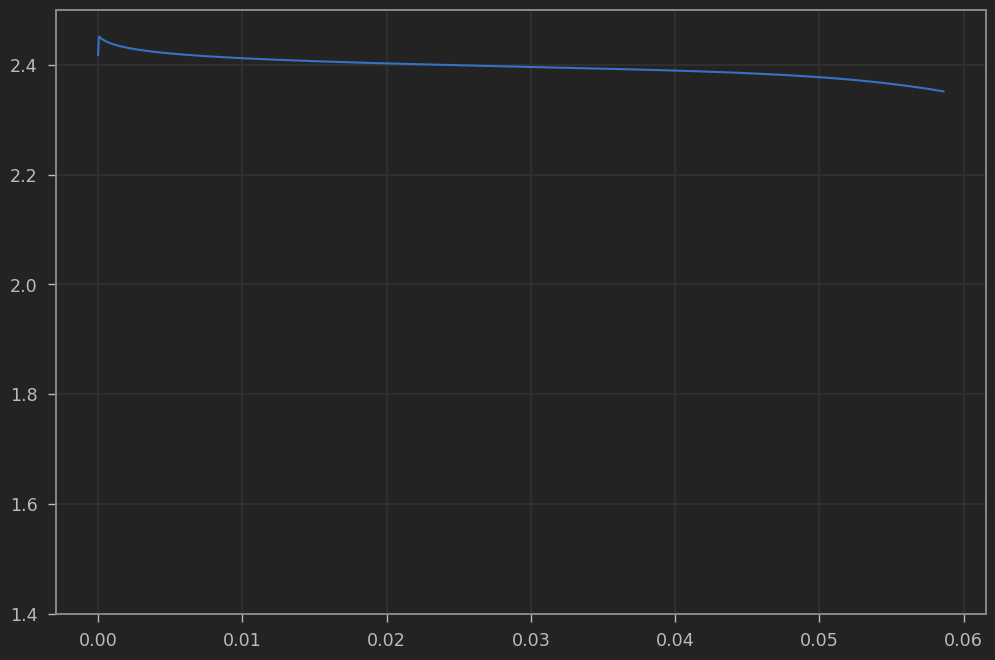

In [3]:
voltage_cornish_pseudospatial = sim_cornish_pseudospatial_quick.solution['Terminal voltage [V]'].entries
capacity_cornish_pseudospatial = abs(current)*sim_cornish_pseudospatial_quick.solution.t/3600
plt.plot(capacity_cornish_pseudospatial,voltage_cornish_pseudospatial)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

In [4]:
x = np.where(voltage_cornish_pseudospatial <= 2.4)
loc = x[0][0]
S8_initial_cornish = sim_cornish_pseudospatial_quick.solution['S8 [g]'].entries[loc]
S6_initial_cornish = sim_cornish_pseudospatial_quick.solution['S6 [g]'].entries[loc]
S4_initial_cornish = sim_cornish_pseudospatial_quick.solution['S4 [g]'].entries[loc]
S2_initial_cornish = sim_cornish_pseudospatial_quick.solution['S2 [g]'].entries[loc]
S_initial_cornish = sim_cornish_pseudospatial_quick.solution['S [g]'].entries[loc]
Sp_initial_cornish = sim_cornish_pseudospatial_quick.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial_cornish = sim_cornish_pseudospatial_quick.solution['Terminal voltage [V]'].entries[loc]

In [5]:
model = pybamm.lithium_sulfur.Cornish_concentration_custom()

# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
current = 2*0.0211
hours = 15
time_in_seconds =15700#hours*3600
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": S8_initial_cornish*1.1,
        "Initial Condition for S6 ion [g]": S6_initial_cornish*0.00025,
        "Initial Condition for S4 ion [g]": S4_initial_cornish*.6,
        "Initial Condition for S2 ion [g]": S2_initial_cornish*0.05,#.05,
        "Initial Condition for S ion [g]": S_initial_cornish,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial_cornish,
        "Initial Condition for Terminal Voltage [V]": 2.4,#V_initial,
        #"Precipitation rate [s-1]": 100,
        "Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 1.8,
        "Standard Potential L [V]": 1.95,
        "Standard Potential M [V]": 1.975,
        "Standard Potential H [V]": 2.38,
        "gamma": 200,#300,
        "kappa" : 30,#25,
        #"S saturation mass [g]": sat,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_con_cust = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_con_cust.solve(np.linspace(0, time_in_seconds, 50000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

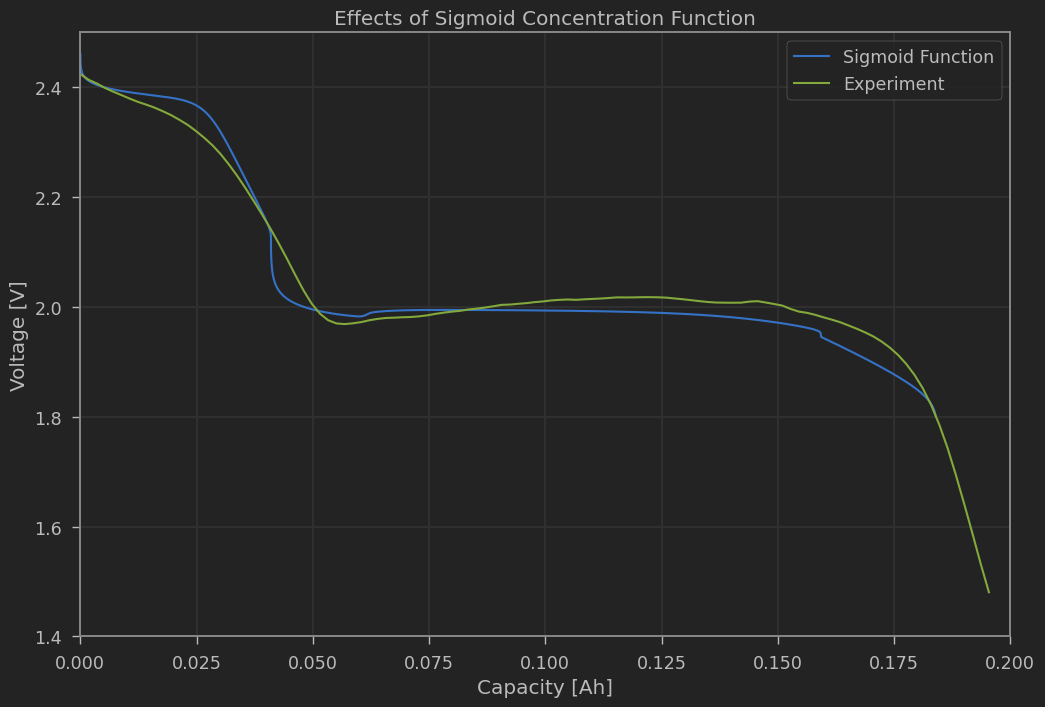

In [6]:
voltage_cornish = sim_con_cust.solution['Terminal voltage [V]'].entries
capacity_cornish = abs(current)*sim_con_cust.solution.t/3600
plt.plot(capacity_cornish,voltage_cornish)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'])

plt.ylim([1.4,2.5])
plt.xlim([0,0.2])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Sigmoid Concentration Function')
plt.legend(['Sigmoid Function', 'Experiment'])
plt.grid(True)
notify

In [7]:
# get charge initial condition
loc = -1
S8_charge_initial_cornish = sim_con_cust.solution['S8 [g]'].entries[loc]
S6_charge_initial_cornish = sim_con_cust.solution['S6 [g]'].entries[loc]
S4_charge_initial_cornish = sim_con_cust.solution['S4 [g]'].entries[loc]
S2_charge_initial_cornish = sim_con_cust.solution['S2 [g]'].entries[loc]
S_charge_initial_cornish = sim_con_cust.solution['S [g]'].entries[loc]
Sp_charge_initial_cornish = sim_con_cust.solution["Precipitated Sulfur [g]"].entries[loc]
V_charge_initial_cornish = sim_con_cust.solution['Terminal voltage [V]'].entries[loc]

In [ ]:
charge_sims = {}
gamma_space = [200]#np.linspace(40,50,5)
kappa_space = [30]#np.linspace(1,100,10)*5

for gamma in gamma_space:
    for kappa in kappa_space:
        try:
            key = str(gamma) + ' ' + str(kappa)
            print("\n\n\n\n\n\n" + key + "\n\n\n\n\n\n")
            model = pybamm.lithium_sulfur.Cornish_concentration_custom()

            # (similar) parameters should be the same as in Marinescu et al. (2018)
            # However, the  initial condition from charge appears to be the result of a discharge
            current = -0.0211
            hours = 15
            time_in_seconds =1000#hours*3600
            params = model.default_parameter_values
            params.update(
                {
                    "Current function [A]": current,
                    "Initial Condition for S8 ion [g]": S8_charge_initial_cornish,#*1.1,
                    "Initial Condition for S6 ion [g]": S6_charge_initial_cornish,#*0.00025,
                    "Initial Condition for S4 ion [g]": S4_charge_initial_cornish,#*.6,
                    "Initial Condition for S2 ion [g]": S2_charge_initial_cornish,#*0.05,#.05,
                    "Initial Condition for S ion [g]": S_charge_initial_cornish,
                    "Initial Condition for Precipitated Sulfur [g]": Sp_charge_initial_cornish,
                    "Initial Condition for Terminal Voltage [V]": 1.4,#V_initial,
                    #"Precipitation rate [s-1]": 100,
                    "Shuttle rate coefficient during charge [s-1]": 0.0002,
                    "Lower voltage cut-off [V]": 1.8,
                    "Standard Potential L [V]": 1.95,
                    "Standard Potential M [V]": 1.975,
                    "Standard Potential H [V]": 2.38,
                    "gamma": gamma,#300,
                    "kappa" : kappa,#25,
                    #"S saturation mass [g]": sat,
                    #"Electrolyte volume per cell [L]": 0.0114*.25
                }
            )
            params.process_model(model)
            sim_charge_con_cust = pybamm.Simulation(
                model,
                parameter_values=params,
                solver=pybamm.CasadiSolver(
                    atol=1e-6, 
                    rtol=1e-3, 
                    extra_options_setup={"max_step_size": 0.1}, 
                    max_step_decrease_count = 15,
                    #root_method = 'lm',
                    #root_tol = 1e-7, 
                    #dt_max = 1e-7
                ),
            )
            sim_charge_con_cust.solve(np.linspace(0, time_in_seconds, 10000))
            
            charge_sims[key] = sim_charge_con_cust
            
        except:
            pass







200 30








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.50085 and h

In [ ]:
keys = charge_sims.keys()
legend = []
for key in keys:
    sim = charge_sims[key]
    legend.append(key)
    voltage_cornish = sim.solution['Terminal voltage [V]'].entries
    capacity_cornish = abs(current)*sim.solution.t/3600
    plt.plot(capacity_cornish,voltage_cornish)

# get experimental data
filename = '/home/drmrfc/Dropbox/Career/2020 - 2023 Post Doc/LiSTAR/Data/Inhomogeneity/Inhomogeneity/LiS_SingleLayers/reworked_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

temp_list = list(discharge_data.keys())

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'])
legend.append("Experiment")

plt.ylim([2,2.3])
plt.xlim([0,0.025])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title('Effects of Sigmoid Concentration Function')
plt.legend(legend)
plt.grid(True)
notify